In [1]:
import pandas as pd

df = pd.read_csv("https://projects.fivethirtyeight.com/polls/data/presidential_general_averages.csv")
df.head()

,candidate,date,pct_trend_adjusted,state,cycle,party,pct_estimate,hi,lo
0,Joseph R. Biden Jr.,2020-11-03,37.82732,Alabama,2020,NaN,NaN,NaN,NaN
1,Donald Trump,2020-11-03,57.36126,Alabama,2020,NaN,NaN,NaN,NaN
2,Joseph R. Biden Jr.,2020-11-02,37.82732,Alabama,2020,NaN,NaN,NaN,NaN
3,Donald Trump,2020-11-02,57.36126,Alabama,2020,NaN,NaN,NaN,NaN
4,Joseph R. Biden Jr.,2020-11-01,38.07011,Alabama,2020,NaN,NaN,NaN,NaN


In [2]:
df.columns

Index(['candidate', 'date', 'pct_trend_adjusted', 'state', 'cycle', 'party',
       'pct_estimate', 'hi', 'lo'],
      dtype='object')

In [3]:
df.state.unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'ME-1', 'ME-2', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'National', 'NE-2',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

In [4]:
df[df['cycle'] == 2024]

,candidate,date,pct_trend_adjusted,state,cycle,party,pct_estimate,hi,lo
21300,Trump,2024-06-01,NaN,Arizona,2024,REP,42.58230,44.760652,40.333890
21301,Kennedy,2024-06-01,NaN,Arizona,2024,IND,9.93237,12.115175,7.536479
21302,Biden,2024-06-01,NaN,Arizona,2024,DEM,37.81355,40.142248,35.402817
21303,Trump,2024-05-31,NaN,Arizona,2024,REP,42.56470,44.683482,40.440715
21304,Kennedy,2024-05-31,NaN,Arizona,2024,IND,9.93182,12.122198,7.753816
...,...,...,...,...,...,...,...,...,...
24343,Kennedy,2024-03-02,NaN,Wisconsin,2024,IND,10.28615,12.852725,7.514286
24344,Biden,2024-03-02,NaN,Wisconsin,2024,DEM,38.73255,41.180613,36.214855
24345,Trump,2024-03-01,NaN,Wisconsin,2024,REP,41.58205,43.986072,39.224702
24346,Kennedy,2024-03-01,NaN,Wisconsin,2024,IND,10.30900,13.044215,7.668578


In [5]:
df = df[df['cycle'] == 2024]

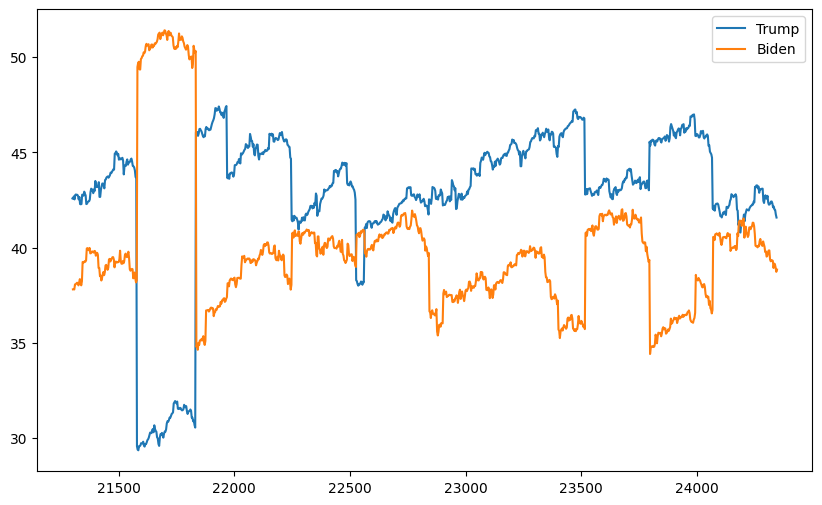

In [6]:
import matplotlib.pyplot as plt
# Plot Trump, Kennedy, Biden
plt.figure(figsize=(10, 6))
for candidate in ['Trump', 'Biden']:
    plt.plot(df[df['candidate'] == candidate]['pct_estimate'])
plt.legend(['Trump', 'Biden'])
plt.show()

In [7]:
# What datatype is the date column?
df['date'].dtype

dtype('O')

In [8]:
# Convert the date column to a datetime object
df['date'] = pd.to_datetime(df['date'])

In [9]:
# What datatype is the date column now?
df['date'].dtype

dtype('<M8[ns]')

In [16]:
from app.models import Session, Headline, Article, Agency
from app.utils import Config, Country
from sqlalchemy import or_
with (Session() as s):
    data = s.query(
        Headline.vader_compound, Headline.afinn, Agency._bias, # noqa prot attr
        Headline.first_accessed, Headline.processed
    ).join(Headline.article).join(Article.agency).filter(
        or_(
            Headline.processed.like('%Trump%'),
            Headline.processed.like('%Biden%'),
        ),
        or_(
            Agency._country == Country.us.value, # noqa prot attr
            Agency.name.in_(Config.exempted_foreign_media)
        )
    ).all()
el = pd.DataFrame(data, columns=['Vader', 'Afinn', 'Bias', 'Date', 'Title'])
el['Date'] = pd.to_datetime(el['Date'])
# Trump and Biden mentions
el['Trump'] = el['Title'].str.contains('Trump', case=False)
el['Biden'] = el['Title'].str.contains('Biden', case=False)
# Group by day and aggregate sentiment
el['PVI'] = el['Vader'] * el['Bias']
el['PAI'] = el['Afinn'] * el['Bias']

In [17]:
el

,Vader,Afinn,Bias,Date,Title,Trump,Biden,PVI,PAI
0,-0.2263,-0.166667,3,2024-02-16 20:07:47.000000,Legal Analyst: It's 'Game Over' if Fani Willis...,True,False,-0.6789,-0.500000
1,-0.7096,-0.166667,-3,2024-02-16 20:07:48.000000,Biden Turns the Screws on MAGA-Republicans ove...,False,True,2.1288,0.500000
2,0.0000,0.214286,-1,2024-02-16 20:07:48.000000,See where the big Trump cases stand in the mon...,True,False,-0.0000,-0.214286
3,-0.5859,-0.181818,2,2024-02-16 20:07:49.000000,"Biden blames businesses for 'shrinkflation,' b...",False,True,-1.1718,-0.363636
4,-0.0258,0.200000,-1,2024-02-16 20:07:50.000000,A stunning indictment could doom Republican's ...,False,True,0.0258,-0.200000
...,...,...,...,...,...,...,...,...,...
108375,-0.3400,-0.250000,3,2024-06-01 20:00:03.891946,Classified Doc Case Renews Bid to Gag Trump,True,False,-1.0200,-0.750000
108376,-0.2960,-0.142857,3,2024-06-01 20:00:03.891946,Rep. Tenney: Everything's Done to Stop Trump,True,False,-0.8880,-0.428571
108377,0.3182,0.000000,3,2024-06-01 20:00:03.891946,Ohio Senate Assures Biden Will Be on Nov. Ballot,False,True,0.9546,0.000000
108378,0.0000,0.000000,3,2024-06-01 20:00:03.891946,"US, Qatar, Egypt Urge Hamas and Israel to Fina...",False,True,0.0000,0.000000


ValueError: x and y must have same first dimension, but have shapes (3048,) and (1016,)

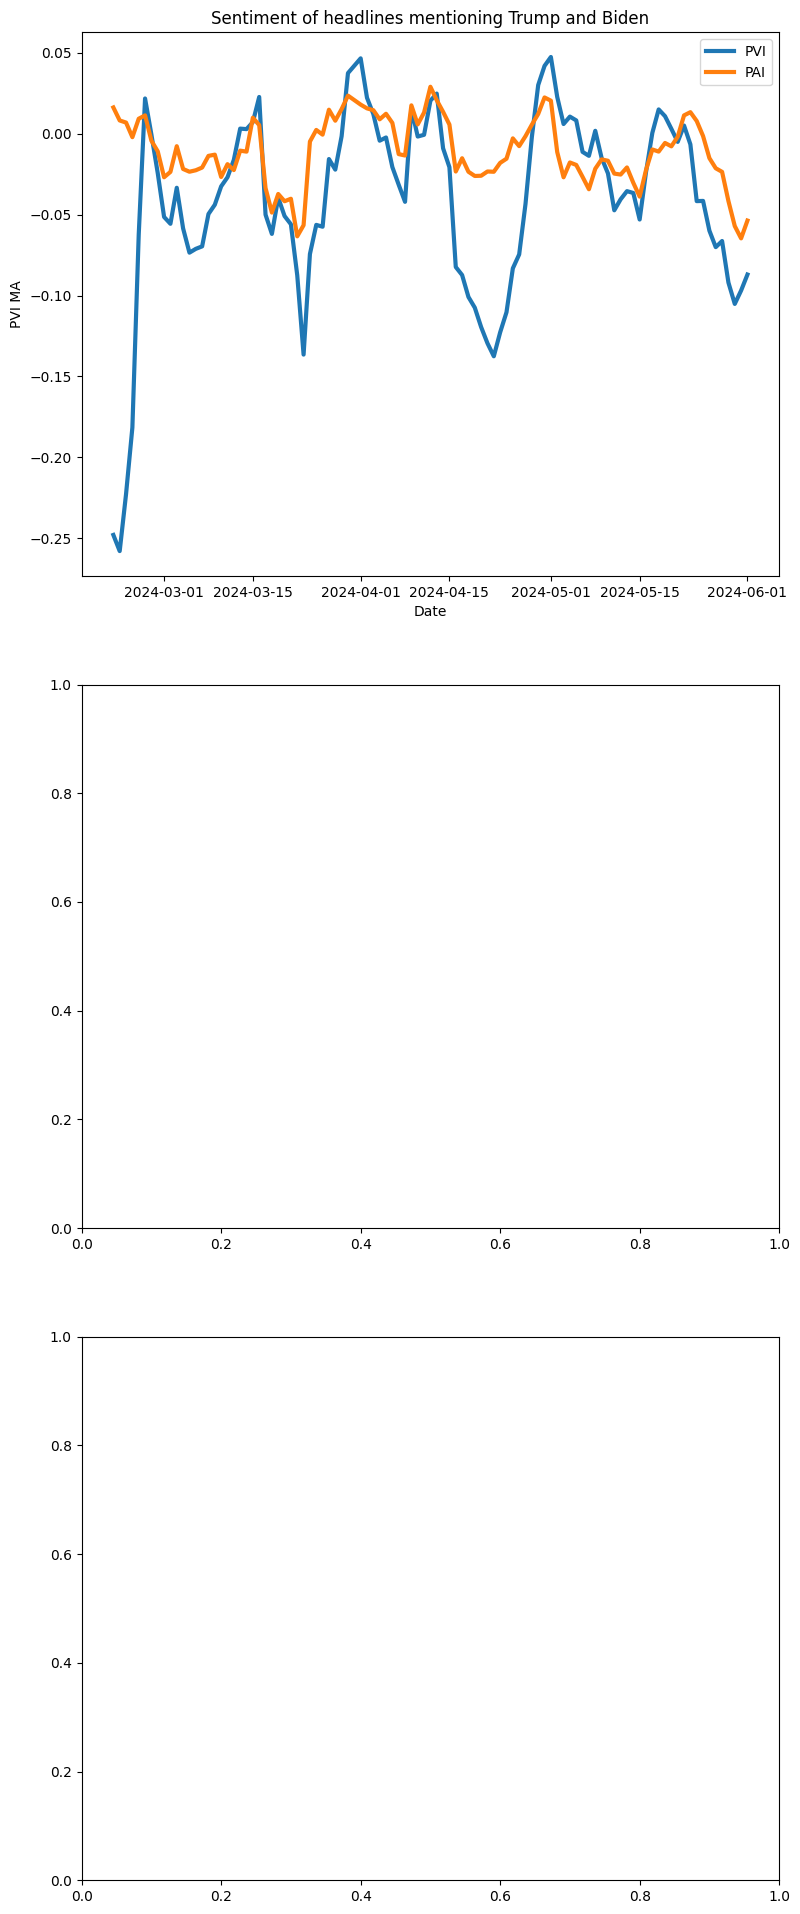

In [18]:
poll_df = df
df = el
import seaborn as sns
def aggregate(df):
    cols = ['Vader', 'Afinn', 'PVI', 'PAI']
    agg = df.set_index('Date').groupby(pd.Grouper(freq='D')) \
        .agg({col: 'mean' for col in cols}).dropna().reset_index()
    # moving averages for vader and afinn
    agg['Vader MA'] = agg['Vader'].rolling(window=7).mean()
    agg['Afinn MA'] = agg['Afinn'].rolling(window=7).mean()
    agg['PVI MA'] = agg['PVI'].rolling(window=7).mean()
    agg['PAI MA'] = agg['PAI'].rolling(window=7).mean()
    return agg

def plot(df, ax, title):
    lw = 3
    # sns.lineplot(x='Date', y='Vader MA', data=df, ax=ax, label='Vader', lw=lw)
    # sns.lineplot(x='Date', y='Afinn MA', data=df, ax=ax, label='Afinn', lw=lw)
    sns.lineplot(x='Date', y='PVI MA', data=df, ax=ax, label='PVI', lw=lw)
    sns.lineplot(x='Date', y='PAI MA', data=df, ax=ax, label='PAI', lw=lw)
    ax.set_title(title)

fig, axes = plt.subplots(3)
fig.set_size_inches(9, 24)

# Trump and Biden
plot(aggregate(df[(df['Trump']) & (df['Biden'])]), axes[0],
     'Sentiment of headlines mentioning Trump and Biden')
pollkey = 'pct_estimate'
axes[0].plot(poll_df['date'], poll_df[poll_df.candidate == 'Trump'][pollkey], label='Trump Polls', lw=3)
axes[0].plot(poll_df['date'], poll_df[poll_df.candidate == 'Biden'][pollkey], label='Biden Polls', lw=3)

plot(aggregate(df[df['Trump']]), axes[1], 'Sentiment of headlines mentioning Trump')
axes[1].plot(poll_df['date'], poll_df[poll_df.candidate == 'Trump'][pollkey], label='Trump Polls', lw=3)

plot(aggregate(df[df['Biden']]), axes[2], 'Sentiment of headlines mentioning Biden')
axes[2].plot(poll_df['date'], poll_df[poll_df.candidate == 'Biden'][pollkey], label='Biden Polls', lw=3)

for i in range(3):
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    # Turn off axis labels
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_xticks(axes[i].get_xticks()[::2])
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=rotation)
    # Hide the spines
    for spine in ['right', 'top', 'left', 'bottom']:
        axes[i].spines[spine].set_visible(False)

    axes[i].legend(
        bbox_to_anchor=(0.5, 1.04), ncol=5, frameon=True, facecolor='lightgray', edgecolor='black',
        framealpha=0.9, fontsize='medium', title_fontsize='large', fancybox=True, shadow=True,
        borderpad=1.2, labelspacing=1.5, loc='lower right'
    )

plt.tight_layout()

In [ ]:
#